#Importing Required Libraries

In [204]:
#Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score

#https://huggingface.co/docs/transformers/training

#Import Data

In [205]:
df = pd.read_csv('insurance.csv') #https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [207]:
num_cols = df.select_dtypes(include=['float64' , 'float32' , 'int64' , 'int32']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

In [208]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [209]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [210]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

<ipython-input-211-cd7e9664a2f3>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

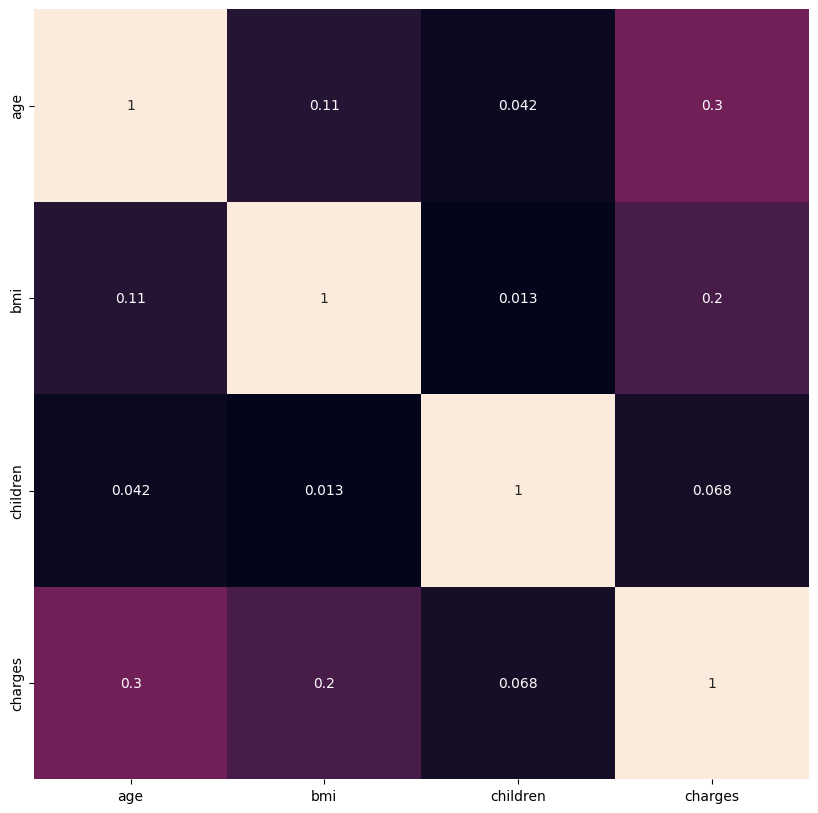

In [211]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),  annot= True , cbar= False)

<Axes: xlabel='age', ylabel='bmi'>

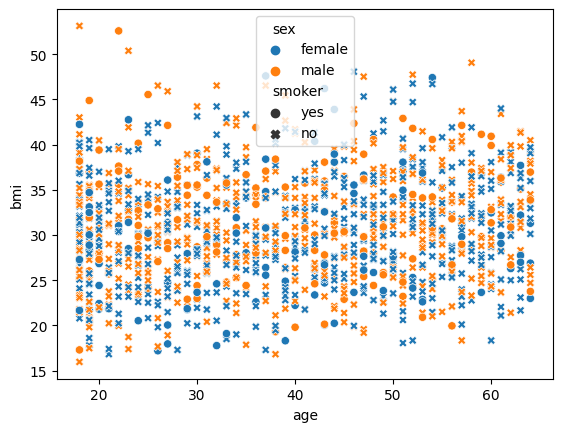

In [212]:
sns.scatterplot(x = "age", y = "bmi", hue = "sex", style = "smoker",data = df)

<Axes: xlabel='age', ylabel='bmi'>

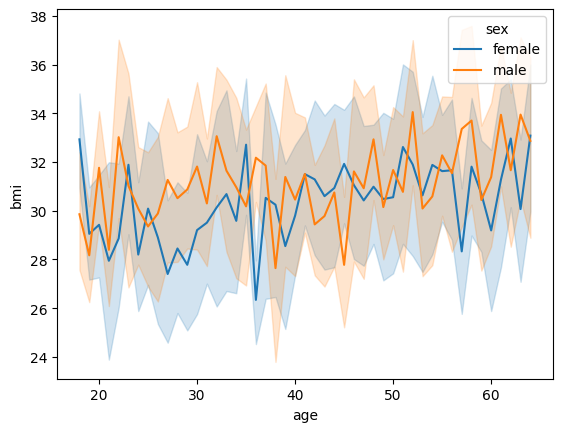

In [213]:
sns.lineplot(x = "age", y = "bmi", hue = "sex",data = df)

In [214]:
df.groupby(["age", "sex"])["bmi"].mean().unstack().head()

sex,female,male
age,,
18,32.930909,29.855139
19,29.051667,28.168143
20,29.421429,31.763333
21,27.944615,28.394667
22,28.859231,33.019000


#Data Preprocessing

In [215]:
df['sex'] = df['sex'].replace(['female' , 'male'] , [0 , 1])
df['smoker'] = df['smoker'].replace(['no' , 'yes'] , [0 , 1])
regions = ['southwest' , 'northwest','southeast' , 'northeast']
df['region'] = df['region'].replace( regions, [0 ,1, 2, 3])

In [216]:
X = df.drop('charges' , axis = 1)
y = df['charges']

In [217]:
num_cols

['age', 'bmi', 'children', 'charges']

In [218]:
sc = StandardScaler()
X[num_cols[:-2]] = sc.fit_transform(X[num_cols[:-2]])
X[num_cols[:-2]] = sc.transform(X[num_cols[:-2]])

In [219]:
X

,age,sex,bmi,children,smoker,region
0,-2.894029,0,-5.104526,0,1,0
1,-2.899098,1,-4.946560,1,0,2
2,-2.848402,1,-4.967282,3,0,2
3,-2.823054,1,-5.244326,0,0,1
4,-2.828124,1,-5.078153,0,0,1
...,...,...,...,...,...,...
1333,-2.736871,1,-5.021910,3,0,1
1334,-2.899098,0,-4.996345,0,0,3
1335,-2.899098,0,-4.863676,0,0,2
1336,-2.883889,0,-5.161038,0,0,0


In [220]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,-2.791587,0.071228,-2.899098,-2.853472,-2.792636,-2.731801,-2.665896
sex,1338.0,0.505232,0.500160,0.000000,0.000000,1.000000,1.000000,1.000000
bmi,1338.0,-5.030161,0.164106,-5.425838,-5.147684,-5.037249,-4.921702,-4.425571
children,1338.0,1.094918,1.205493,0.000000,0.000000,1.000000,2.000000,5.000000
smoker,1338.0,0.204783,0.403694,0.000000,0.000000,0.000000,0.000000,1.000000
region,1338.0,1.513453,1.104915,0.000000,1.000000,2.000000,2.000000,3.000000


In [221]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1338 entries, 0 to 1337
Series name: charges
Non-Null Count  Dtype  
--------------  -----  
1338 non-null   float64
dtypes: float64(1)
memory usage: 10.6 KB


In [222]:
y.describe().T

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

#Perform An Exploratory Data Analysis

##Examine the distribution of Bmi (Body Mass Index)

In [223]:
df['bmi'].describe()

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64

<ipython-input-224-5a0701d4a6aa>:5: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



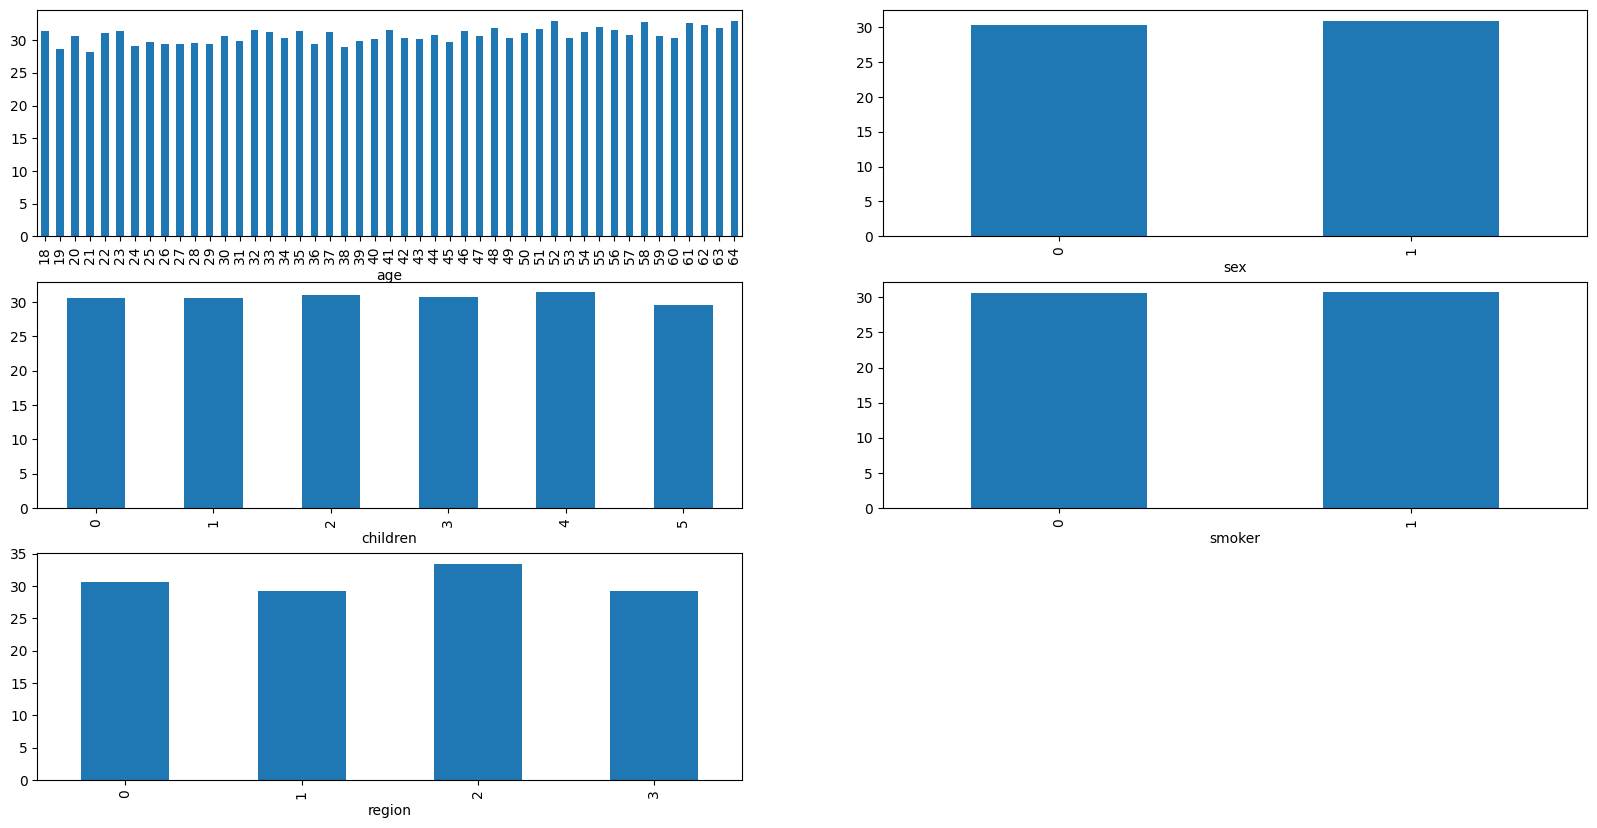

In [224]:
features = ['age', 'sex', 'children', 'smoker', 'region']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(3, 2, i + 1)
    df.groupby(col).mean()['bmi'].plot.bar()
plt.show()

##Examine the relationship between “smoker” and “charges”

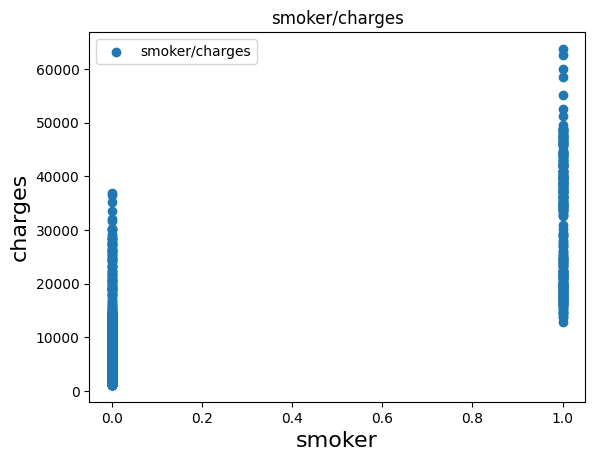

In [225]:
plt.scatter(df['smoker'], df['charges'], label = "smoker/charges")
plt.xlabel("smoker", fontsize = 16)
plt.ylabel("charges", fontsize = 16)
plt.title("smoker/charges")
plt.legend()
plt.show()

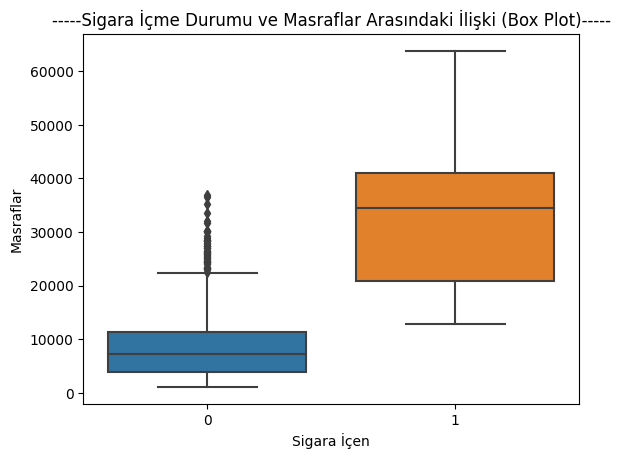

In [226]:
sns.boxplot(x="smoker", y="charges", data=df)
plt.xlabel('Sigara İçen')
plt.ylabel('Masraflar')
plt.title('-----Sigara İçme Durumu ve Masraflar Arasındaki İlişki (Box Plot)-----')
plt.show()

In [227]:
df.groupby("smoker")["charges"].mean().head()
# Yukarıda sigara içenlerin daha fazla sağlık masraflarına sahip olduğu gözükmektedir.

smoker
0     8434.268298
1    32050.231832
Name: charges, dtype: float64

##Examine the relationship between “smoker” and “region”.

<Axes: xlabel='region', ylabel='charges'>

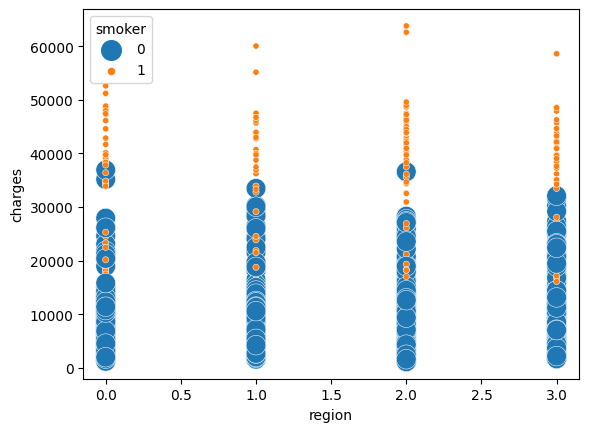

In [228]:
sns.scatterplot(
    data=df, x="region", y="charges", hue="smoker", size="smoker",
    sizes=(20, 200), legend="full",
)


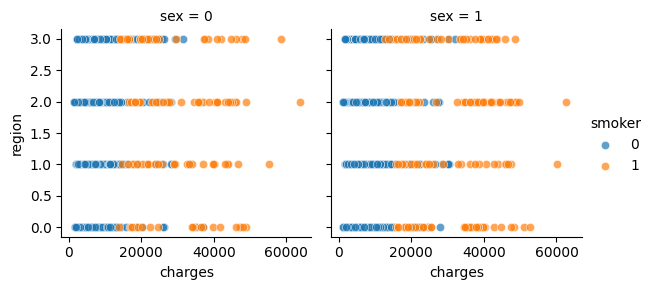

In [229]:
g = sns.FacetGrid(df, col="sex", hue="smoker")
g.map(sns.scatterplot, "charges", "region", alpha=.7)
g.add_legend()



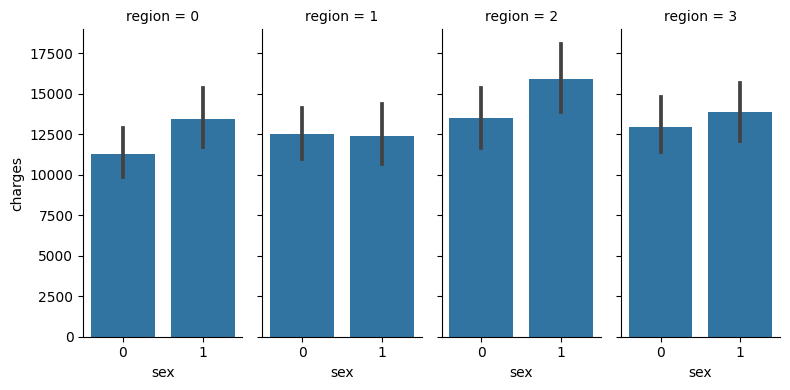

In [230]:
g = sns.FacetGrid(df, col="region", height=4, aspect=.5)
g.map(sns.barplot, "sex", "charges", order=[0,1])

<ipython-input-231-699ebfa800cd>:17: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



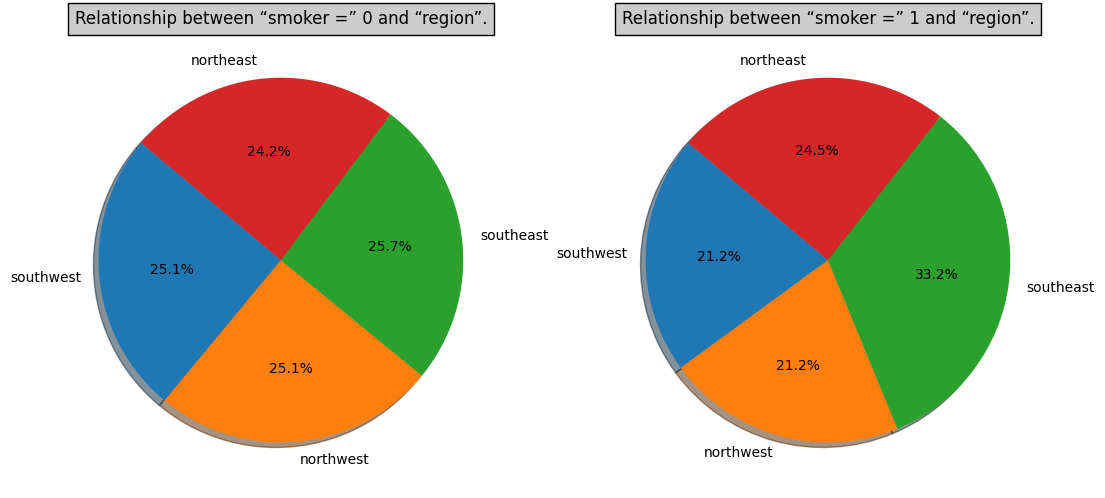

In [231]:
df['smoker'].value_counts()

A = [[0,0,0,0],[0,0,0,0]]
for i in range(0,2):
  for j in range(0,4):
    A[i][j] = len(df[(df['smoker'] == i) & ( df['region'] == j)])

A[0] = A[0] / np.sum(A[0])
A[1] = A[1] / np.sum(A[1])

mylabels = ['southwest' , 'northwest','southeast' , 'northeast']
#colors = ['red', 'gold', 'yellowgreen', 'blue', 'lightcoral', 'lightskyblue']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

plt.subplots(figsize=(20, 10))
for i in range(0,2):
    plt.subplot(1, 3, i + 1)

    x = df[col].value_counts()
    plt.pie(A[i], labels=mylabels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title(f"Relationship between “smoker =” {i} and “region”.", bbox={'facecolor':'0.8', 'pad':5})

plt.show()

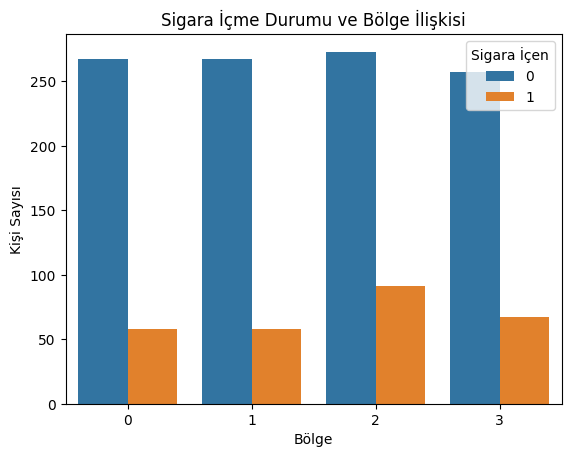

In [232]:
sns.countplot(x="region", hue="smoker", data=df)
plt.xlabel('Bölge')
plt.ylabel('Kişi Sayısı')
plt.title('Sigara İçme Durumu ve Bölge İlişkisi')
plt.legend(title="Sigara İçen")
plt.show()


<Axes: xlabel='region', ylabel='smoker'>

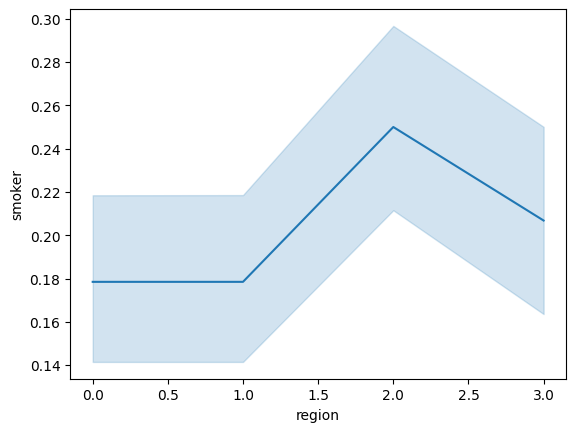

In [233]:
sns.lineplot(x = 'region',y = 'smoker',data = df)
# Yukarıda baktığımız zaman en çok southeast bölgesinde sigara kullanıldığını ve genel olarak sigara kullanmayan kişi sayısının daha fazla olduğunu söyleyebiliriz.

##Examine the relationship between “bmi” and “sex”.

In [234]:
df['bmi'].cov(df['sex'])

0.1414350949686568

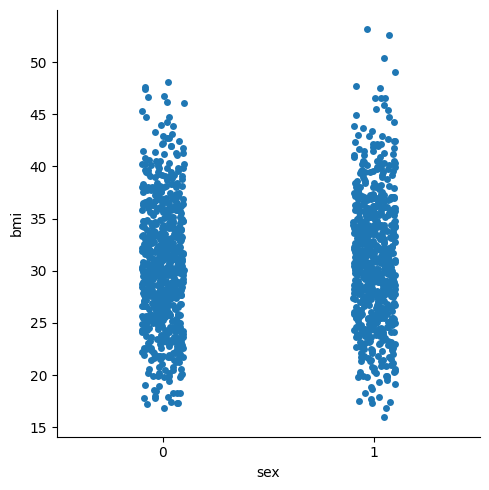

In [235]:
sns.catplot(x = 'sex',y = 'bmi',data = df)

<Axes: xlabel='sex', ylabel='bmi'>

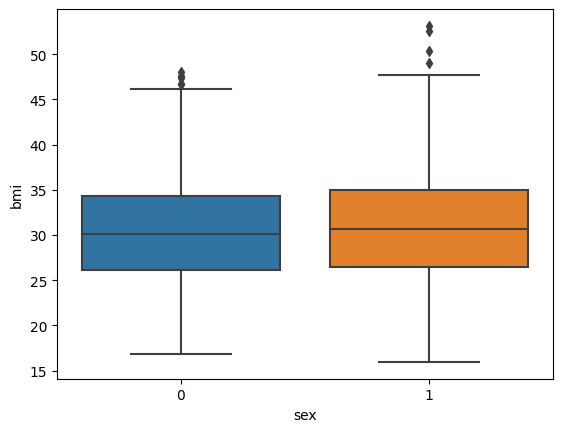

In [236]:
sns.boxplot(x = 'sex',y = 'bmi',data = df)

In [237]:
df.groupby("sex")["bmi"].mean().head()

sex
0    30.377749
1    30.943129
Name: bmi, dtype: float64

##Find the "region" with the most "children".

In [238]:
A = [0,0,0,0]
for i in range (0,5):
  for k,j in df[df['region'] == i].children.value_counts().items():
    A[i] += k*j
np.sum(A) == np.sum(df['children'])
regions[np.array(A).argmax()]

'southeast'

In [239]:
df.groupby("region")["children"].sum().head().sort_values(ascending=False)
# En fazla çocuğa sahip olan bölgenin southeast olduğu gözükmekte

region
2    382
1    373
0    371
3    339
Name: children, dtype: int64

##Examine the relationship between “age” and “bmi”.

In [240]:
df['bmi'].cov(df['age'])

9.362336626407425

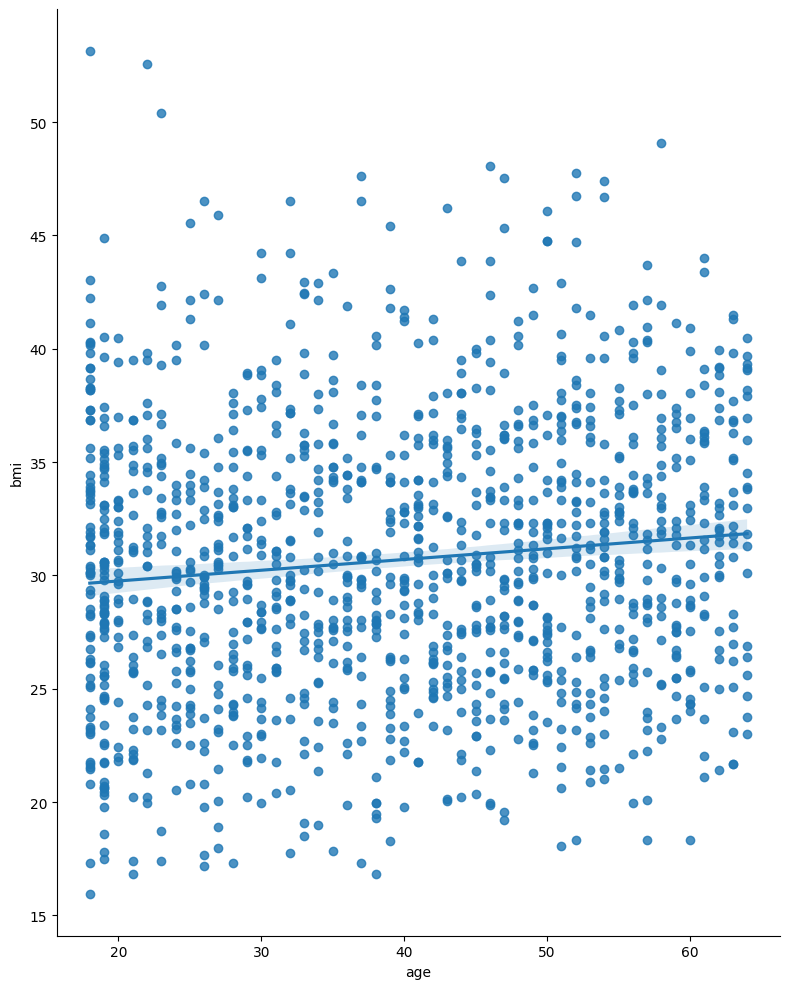

In [241]:
sns.lmplot(x="age", y="bmi", height=10, aspect=0.8,data = df)

In [242]:
df.groupby(["age","sex"])["bmi"].mean().head().unstack()

sex,0,1
age,,
18,32.930909,29.855139
19,29.051667,28.168143
20,29.421429,NaN


In [243]:
df_heatmap = df.pivot_table(index="age", columns="sex", values="bmi")
df_heatmap.head()

sex,0,1
age,,
18,32.930909,29.855139
19,29.051667,28.168143
20,29.421429,31.763333
21,27.944615,28.394667
22,28.859231,33.019000


<Axes: xlabel='sex', ylabel='age'>

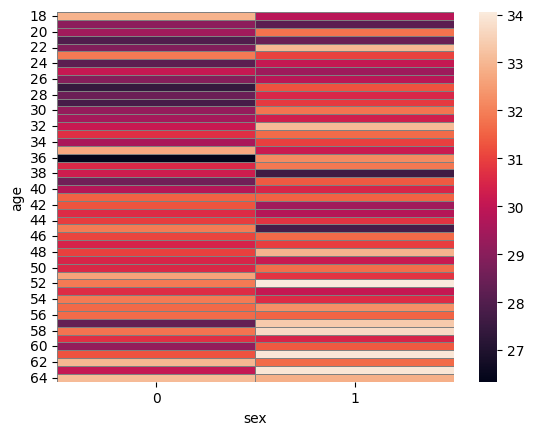

In [244]:
sns.heatmap(df_heatmap,linewidths=0.5, linecolor='gray')
# Yukarıda kadın ve erkeklerin ait oldukları yaşlara göre sahip olduğu ortalama bmi'lerini (vicut kütle indekslerini) görüyoruz.

##Examine the relationship between “bmi” and “children”.

In [245]:
df['bmi'].cov(df['children'])

0.09379476339170419

In [246]:
bins = [0, 18, 25, 30, 35, 100]  # Belirli aralıklar
labels = ['0-18 zayıf', '18-25 normal', '25-30 kilolu', '30-35 obez', '35++ aşırı obez']  # Aralık etiketleri

df['bmi_group'] = pd.cut(df['bmi'], bins=bins, labels=labels)

df.groupby(['bmi_group'])[['children']].sum()

#Bmi değerlerine göre sahip olunan çocukları yada ortalamasını görmek pek mümkün olmaz çünkü bmi değeri çok sayıda eşsiz değerden oluşmakta bunun yerine bmi değerlerini belirli aralıklarda alarak bu aralıklardaki bmi değerine sahip bireylerin çocuk sayılarını veya kişi başına düşen ortalama çocuk sayısını hesaplamak daha mantıklı olur.

#Yukarıdaki örnekte, pd.cut() fonksiyonu ile "bmi" değerlerini belirli aralıklara böldük ve her bir aralığa bir kategori etiketi atadık. Ardından groupby ile bu yeni kategorilere göre gruplama yaparak toplam çocuk değerlerini hesapladık.

,children
bmi_group,
0-18 zayıf,16
18-25 normal,260
25-30 kilolu,408
30-35 obez,448
35++ aşırı obez,333


In [247]:
df.groupby(['bmi_group'])[['children']].describe()

children                                             
                   count      mean       std  min  25%  50%  75%  max
bmi_group                                                            
0-18 zayıf          15.0  1.066667  0.883715  0.0  0.0  1.0  2.0  2.0
18-25 normal       232.0  1.120690  1.256362  0.0  0.0  1.0  2.0  5.0
25-30 kilolu       386.0  1.056995  1.213288  0.0  0.0  1.0  2.0  5.0
30-35 obez         389.0  1.151671  1.220583  0.0  0.0  1.0  2.0  5.0
35++ aşırı obez    316.0  1.053797  1.154818  0.0  0.0  1.0  2.0  5.0

In [248]:
#Burda bmiye göre insanların sahip olduğu çocuklar hakkında bilgi sahibi oluyoruz. Zayıf ve aşırı obez insanların normal-obez aralığındaki insanlara göre daha az çocuk sahibi olduğunu söylemek mümkün.

In [249]:
df[["bmi_group"]].value_counts()

bmi_group      
30-35 obez         389
25-30 kilolu       386
35++ aşırı obez    316
18-25 normal       232
0-18 zayıf          15
dtype: int64

In [250]:
bmi_ortalama = df.groupby(["bmi_group"])["bmi"].mean().reset_index()
bmi_ortalama.columns = ["bmi_group", "bmi_ortalama"]
bmi_ortalama

,bmi_group,bmi_ortalama
0,0-18 zayıf,17.331333
1,18-25 normal,22.543039
2,25-30 kilolu,27.628497
3,30-35 obez,32.351350
4,35++ aşırı obez,38.887326


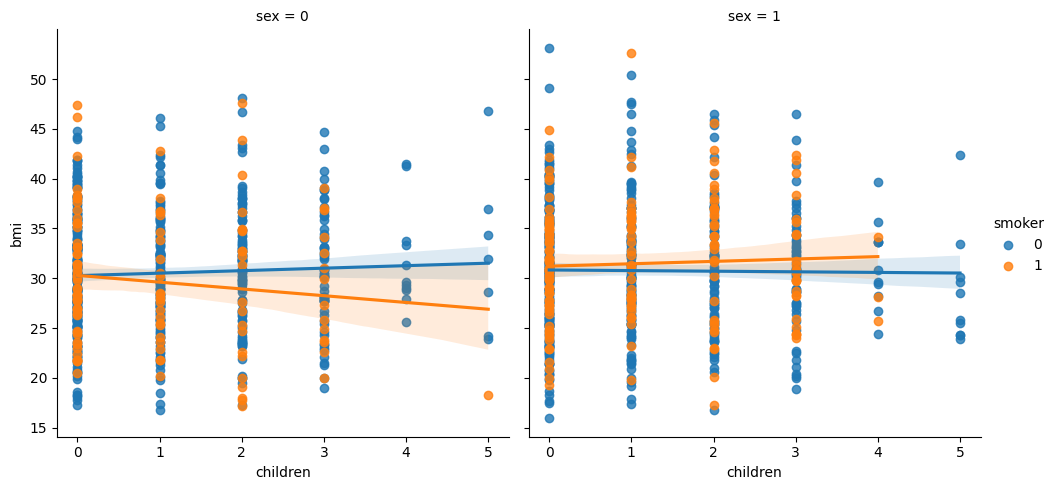

In [251]:
sns.lmplot(x="children", y="bmi", hue="smoker",col="sex",height=5,data = df)

##Is there an outlier in the "bmi" variable? Please review.

In [252]:
df.describe()[['bmi']]

,bmi
count,1338.000000
mean,30.663397
std,6.098187
min,15.960000
25%,26.296250
50%,30.400000
75%,34.693750
max,53.130000


In [253]:
import plotly.express as px #https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/

fig = px.box(df, x='bmi')
fig.show()

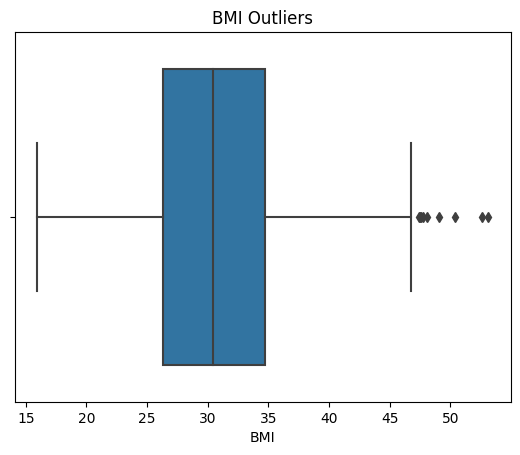

In [254]:
sns.boxplot(x=df['bmi'])
plt.xlabel('BMI')
plt.title('BMI Outliers')
plt.show()

IQR (Interquartile Range) Method
Bu yöntemde verilerin çeyrekler arası aralığı (IQR) kullanılarak aykırı değerleri belirlemek mümkündür. Alt ve üst sınırlar hesaplanır ve bu sınırların dışındaki değerler aykırı olarak kabul edilir.

In [255]:
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df[(df['bmi'] < lower_limit) | (df['bmi'] > upper_limit)]

,age,sex,bmi,children,smoker,region,charges,bmi_group
116,58,1,49.06,0,0,2,11381.32540,35++ aşırı obez
286,46,0,48.07,2,0,3,9432.92530,35++ aşırı obez
401,47,1,47.52,1,0,2,8083.91980,35++ aşırı obez
543,54,0,47.41,0,1,2,63770.42801,35++ aşırı obez
847,23,1,50.38,1,0,2,2438.05520,35++ aşırı obez
860,37,0,47.60,2,1,0,46113.51100,35++ aşırı obez
1047,22,1,52.58,1,1,2,44501.39820,35++ aşırı obez
1088,52,1,47.74,1,0,2,9748.91060,35++ aşırı obez
1317,18,1,53.13,0,0,2,1163.46270,35++ aşırı obez


Z-Score Method
Bu yöntemde her bir veri noktasının standart sapma cinsinden uzaklığı hesaplanır. Belirli bir eşik değerinden büyük veya küçük olan veriler aykırı olarak kabul edilir.

In [256]:
from scipy import stats

z_scores = stats.zscore(df['bmi'])
df[(z_scores < -3) | (z_scores > 3)]

,age,sex,bmi,children,smoker,region,charges,bmi_group
116,58,1,49.06,0,0,2,11381.3254,35++ aşırı obez
847,23,1,50.38,1,0,2,2438.0552,35++ aşırı obez
1047,22,1,52.58,1,1,2,44501.3982,35++ aşırı obez
1317,18,1,53.13,0,0,2,1163.4627,35++ aşırı obez


##Examine the relationship between “bmi” and “charges”.

In [257]:
df['bmi'].cov(df['charges'])

14647.30442632216

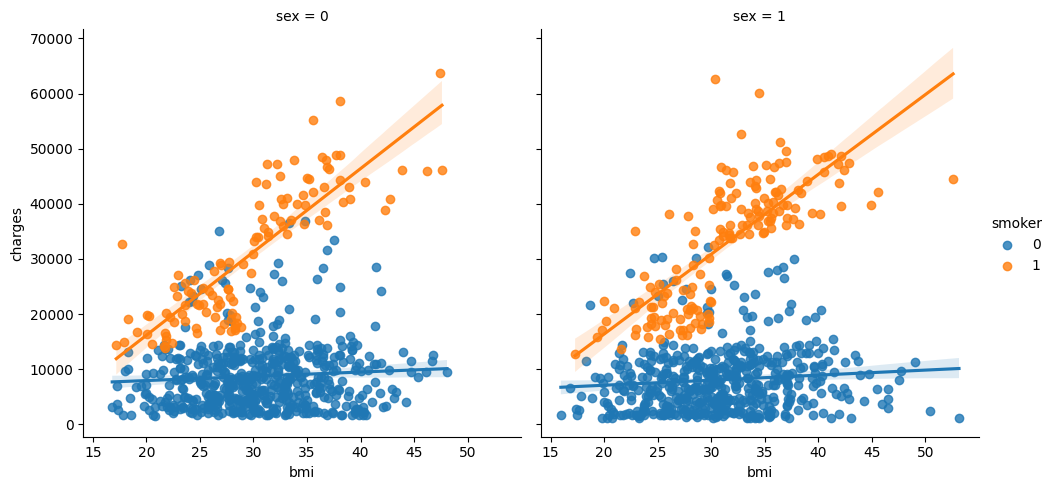

In [258]:
sns.lmplot(x="bmi", y="charges", hue="smoker",col="sex",data = df)

Yukarıdaki modelden;

sigara içen insanların içmeyenlere göre daha fazla sağlık problemi yaşadığını söylemek mümkün.
Kilolu insanlarında normal kilodaki insanlara göre daha fazla sağlık harcaması olduğunu söylemek mümkün.

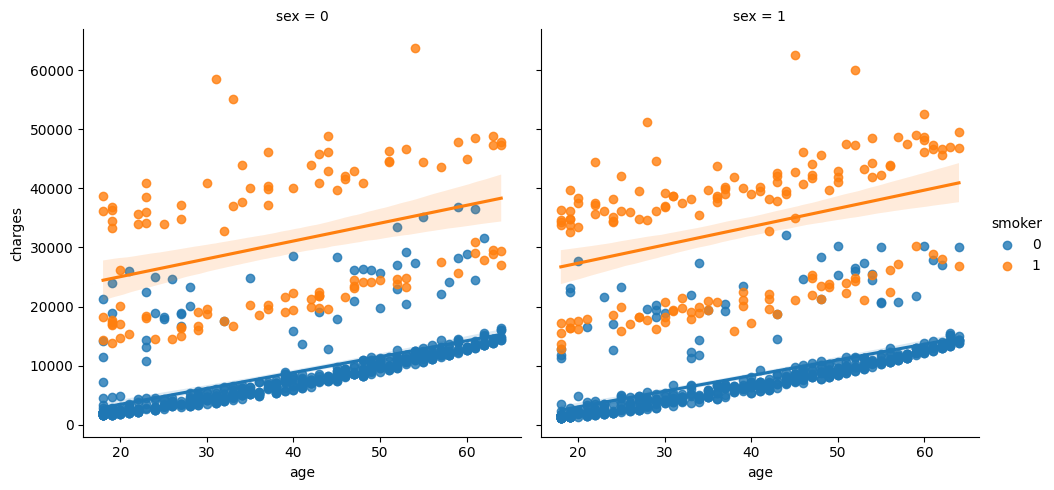

In [259]:
sns.lmplot(x="age", y="charges", hue="smoker",col="sex",data = df)

##Examine the relationship between “region”, “smoker” and “bmi” using bar plot.

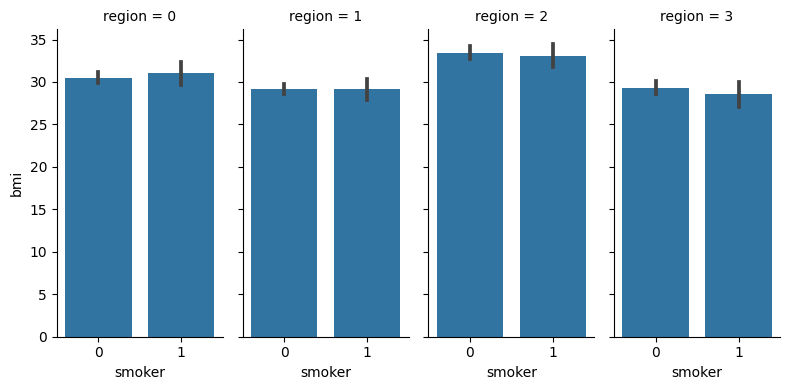

In [260]:
g = sns.FacetGrid(df, col="region", height=4, aspect=.5)
g.map(sns.barplot, "smoker", "bmi", order=[0, 1])

<Axes: xlabel='bmi', ylabel='region'>

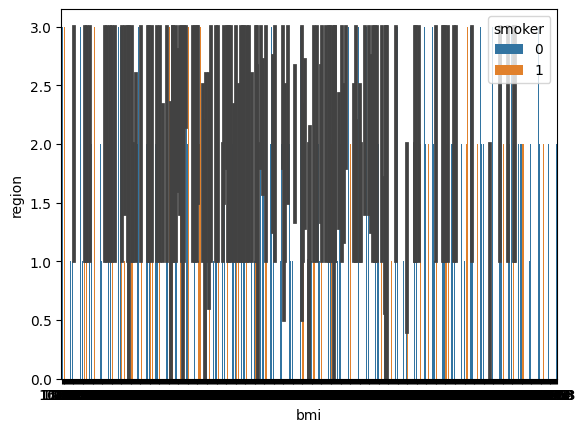

In [261]:
sns.barplot(x="bmi", y="region", hue="smoker", data = df)

Güneyde yaşayan insanların kuzeydekilere nazaran daha kilolu olduklarını söylemek mümkün

#Model Selection

In [262]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.3 , random_state = 0)

###Tuned XGB

In [263]:
vanilla_xgb = XGBRegressor()

param_dist = {
    'n_estimators': np.arange(100,2000,100), # [100,200,300,400,....,2000]
    'max_depth' : np.arange(2, 12 , 1),
    'learning_rate': np.arange(0.01 , 1 , 0.05),
    'subsample': [0.5 , 0.6 , 0.7, 0.8 , 0.9 , 1]
}

random_model = RandomizedSearchCV(vanilla_xgb , param_dist , n_iter = 30 , cv = 5 , scoring = 'neg_mean_squared_error')

random_model.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'learning_rate': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]),
                                        'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]),
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1]},
                   scoring='neg_mean_squared_error')

In [264]:

random_model.best_params_

{'subsample': 0.6,
 'n_estimators': 500,
 'max_depth': 2,
 'learning_rate': 0.060000000000000005}

In [265]:

tuned_xgb = random_model.best_estimator_

In [266]:
def eval_metrics(y_test , y_pred):
  mae = mean_absolute_error(y_test , y_pred)
  mse = mean_squared_error(y_test , y_pred)
  rmse = mean_squared_error(y_test , y_pred) ** 0.5
  r2 = r2_score(y_test , y_pred)

  print(f"""
  MAE : {mae}
  MSE : {mse}
  RMSE : {rmse}
  R2 : {r2}
  """)


y_pred = tuned_xgb.predict(X_test)
eval_metrics(y_test , y_pred)


  MAE : 2538.404630794747
  MSE : 18925469.80370292
  RMSE : 4350.3413433549
  R2 : 0.8813222970886865
  


###Tuned LGBM

In [267]:
vanilla_lgb = LGBMRegressor()

params = {
    'n_estimators' : [100, 300 , 600 , 1000],
    'max_depth' : [3, 5, 7] ,
    'learning_rate' : [0.01 , 0.07 , 0.1],
    'subsample' : [0.5 , 0.8 , 1]
}

grid_model = GridSearchCV(vanilla_lgb , params , scoring= 'neg_mean_squared_error' , cv = 5 )
grid_model.fit(X_train , y_train)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.07, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 300, 600, 1000],
                         'subsample': [0.5, 0.8, 1]},
             scoring='neg_mean_squared_error')

In [268]:


grid_model.best_estimator_

LGBMRegressor(learning_rate=0.01, max_depth=3, n_estimators=600, subsample=0.5)

In [269]:

grid_model.best_score_


-22286039.418796726

In [270]:

grid_model.best_params_


{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 600, 'subsample': 0.5}

In [271]:

tuned_lgb = grid_model.best_estimator_


In [272]:

y_pred = tuned_lgb.predict(X_test)
eval_metrics(y_test , y_pred)


  MAE : 2458.723119044982
  MSE : 17031197.364997182
  RMSE : 4126.887127726803
  R2 : 0.8932008873718098
  
